In [1]:
import os, glob, re, random, gzip, pysam, pyBigWig
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from matplotlib_venn import *
import seaborn as sns
from pyBioInfo.Range import GRange
from pyBioInfo.IO.File import BedFile
from pyBioInfo.Utils import ShiftLoader

# Maximal genomic coverage (exclude Ns)

In [2]:
blanks = defaultdict(int)
with gzip.open("/home/chenzonggui/species/homo_sapiens/GRCh38.p13/GRCh38.canonical.genome.Ns.bed.gz", "rt") as f:
    for line in f:
        chrom, start, end = line.strip("\n").split("\t")[:3]
        blanks[chrom] += int(end) - int(start)
a, b = 0, 0
with open("/home/chenzonggui/species/homo_sapiens/GRCh38.p13/GRCh38.canonical.genome.sizes") as f:
    for line in f:
        chrom, length = line.strip("\n").split("\t")
        if re.match("^chr[0-9]+$", chrom):
            a += int(length)
            b += blanks[chrom]
print(a, b, b / a, sep="\t")
r = 1 - b / a
print("Maximal genomic coverage:", r)

max_genomic_coverage = r

2875001522	118670481	0.041276667191969575
Maximal genomic coverage: 0.9587233328080305


# Genomic coverage and base depth

In [3]:
def load_base_depth(path):
    data = dict()
    with open(path) as f:
        for line in f:
            depth, count = line.strip("\n").split("\t")
            data[int(depth)] = int(count)
    return data

def get_genomic_coverage(data, min_cov=1):
    v1 = 0
    v2 = 0
    for k, v in data.items():
        v1 += v
        if k >= min_cov:
            v2 += v
    r = v2 / v1
    return r

names = ["PacBio", "Ultralong", "NSS"]
repeats = [1, 2]
covs = [2, 4, 6, 8, 10, 12, 14, 16, 20]

base_depths = dict() # base depth
genomic_coverages = dict() # genomic coverage
for name in names:
    for cov in covs:
        for rep in repeats:
            path = "../../nss-pseudobulk-analysis/results/base_depth/%s.cov%d-r%d.tsv" % (name, cov, rep)
            d = load_base_depth(path)
            r = get_genomic_coverage(d)
            base_depths[(name, cov, rep)] = d
            genomic_coverages[(name, cov, rep)] = r

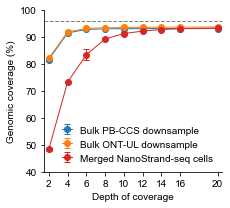

In [4]:
labels = ["Bulk PB-CCS downsample", "Bulk ONT-UL downsample", "Merged NanoStrand-seq cells"]
markers = ["o", "o", "o"]
colors = ["C0", "C1", "C3"]
plt.figure(figsize=(3.3, 3))
xs = np.arange(len(covs))
xs = covs
for i, name in enumerate(names):
    rows = []
    for rep in repeats:
        row = [genomic_coverages[(name, cov, rep)] * 100 for cov in covs]
        rows.append(row)    
    df = pd.DataFrame(rows)
    df.index = repeats
    df.columns = covs
    ys = df.mean(axis=0)
    std = df.std(axis=0)
    plt.errorbar(xs, ys, yerr=std, color=colors[i], marker=markers[i], label=labels[i], capsize=3, lw=1)
plt.axhline(max_genomic_coverage * 100, ls="--", color="grey", lw=1)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xticks(xs, covs)
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.ylim(40, 100)
plt.xlabel("Depth of coverage")
plt.ylabel("Genomic coverage (%)")
plt.legend(loc="lower right", bbox_to_anchor=(1, 0), frameon=False, handlelength=1)
plt.tight_layout()
plt.savefig("figures/genomic_coverage_vs_depth_of_coverage.pdf", dpi=300)

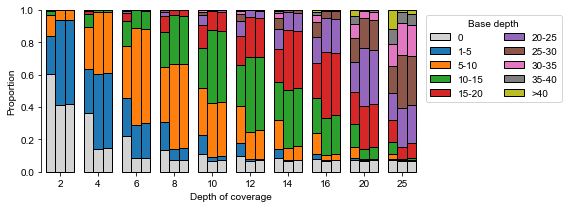

In [51]:
n = 10
step = 5
width = 0.25
colors = ["lightgrey", "C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C0", "C1"]

labels = []
for i in range(n):
    if i == 0:
        labels.append("0")
    elif i == n - 1:
        v2 = i * step - step
        labels.append(">%d" % v2)
    else:
        v2 = i * step
        v1 = max(v2 - step, 1)
        labels.append("%d-%d" % (v1, v2))

plt.figure(figsize=(8, 3))

for i, name in enumerate(names):
    xs = np.arange(len(covs)) + (i - 1) * width
    bottoms = np.zeros(len(covs))
    m = np.zeros((len(covs), n))
    for j, cov in enumerate(covs):
        for k in repeats:
            for depth, count in base_depths[(name, cov, k)].items():
                idx = 0
                if depth > 1:
                    idx = int(depth / step) + 1
                idx = min(idx, n - 1)
                m[j][idx] += count
            break
    m = m / np.sum(m, axis=1)
    
    for idx in range(n):
        ys = m[:,idx]
        label = None
        if i == 0:
            label = labels[idx]
        plt.bar(xs, ys, bottom=bottoms, edgecolor="black", width=width, label=label, color=colors[idx], clip_on=False)
        bottoms += ys
    
    # break
xs = np.arange(len(covs))
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.xticks(xs, covs)
plt.xlabel("Depth of coverage")
plt.ylabel("Proportion")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Base depth", ncol=2)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

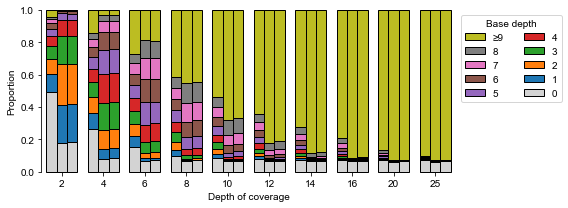

In [50]:
max_base_depth = 9
width = 0.25

plt.figure(figsize=(8, 3))
xyb = dict()
for base_depth in np.arange(max_base_depth + 1):
    xyb[base_depth] = [list(), list(), list()]
for i, name in enumerate(names):
    for j, cov in enumerate(covs):
        counter = defaultdict(int)
        for k, v in base_depths[(name, cov, 1)].items():
            k = min(k, max_base_depth)
            counter[k] += v
        total = sum(counter.values())
        x = j + i * width - width
        bottom = 0
        for base_depth in np.arange(0, max_base_depth + 1):
            y = counter[base_depth] / total
            xyb[base_depth][0].append(x)
            xyb[base_depth][1].append(y)
            xyb[base_depth][2].append(bottom)
            bottom += y
labels = [str(v) for v in np.arange(max_base_depth + 1)]
labels[-1] = "≥%s" % labels[-1]
colors = ["lightgrey", "C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C0", "C1"]
for base_depth, (xs, ys, bottoms) in list(xyb.items())[::-1]:
    plt.bar(xs, ys, bottom=bottoms, edgecolor="black", width=width, label=labels[base_depth], color=colors[base_depth], clip_on=False)
xs = np.arange(len(covs))
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.xticks(xs, covs)
plt.xlabel("Depth of coverage")
plt.ylabel("Proportion")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Base depth", ncol=2)
plt.ylim(0, 1)
plt.tight_layout()
# plt.savefig("figures/proportion_of_base_depth.pdf", dpi=300)

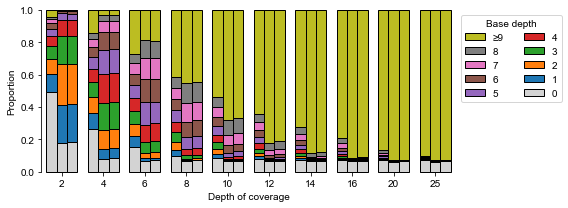

In [5]:
max_base_depth = 9
width = 0.25

plt.figure(figsize=(8, 3))
xyb = dict()
for base_depth in np.arange(max_base_depth + 1):
    xyb[base_depth] = [list(), list(), list()]
for i, name in enumerate(names):
    for j, cov in enumerate(covs):
        counter = defaultdict(int)
        for k, v in base_depths[(name, cov, 1)].items():
            k = min(k, max_base_depth)
            counter[k] += v
        total = sum(counter.values())
        x = j + i * width - width
        bottom = 0
        for base_depth in np.arange(0, max_base_depth + 1):
            y = counter[base_depth] / total
            xyb[base_depth][0].append(x)
            xyb[base_depth][1].append(y)
            xyb[base_depth][2].append(bottom)
            bottom += y
labels = [str(v) for v in np.arange(max_base_depth + 1)]
labels[-1] = "≥%s" % labels[-1]
colors = ["lightgrey", "C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9", "C0", "C1"]
for base_depth, (xs, ys, bottoms) in list(xyb.items())[::-1]:
    plt.bar(xs, ys, bottom=bottoms, edgecolor="black", width=width, label=labels[base_depth], color=colors[base_depth], clip_on=False)
xs = np.arange(len(covs))
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.xticks(xs, covs)
plt.xlabel("Depth of coverage")
plt.ylabel("Proportion")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Base depth", ncol=2)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("figures/proportion_of_base_depth.pdf", dpi=300)

# GIAB SNVs depths

In [6]:
sources = ["NanoSSCell", "Ultralong", "PacBio"]
repeats = [1, 2]
covs = [2, 4, 6, 8, 10, 12, 14, 16, 20, 25]

snv_depths = dict()
for source in sources:
    for cov in covs:
        for rep in repeats:
            path = "../../6_SNV_SV_Comparison/results/snv_depth/%s.cov%d-r%d.json" % (source, cov, rep)
            d = json.load(open(path))
            for s in ["HOM", "HET"]:
                d[s] = {int(k): v for k, v in d[s].items()}
            snv_depths[(source, cov, rep)] = d

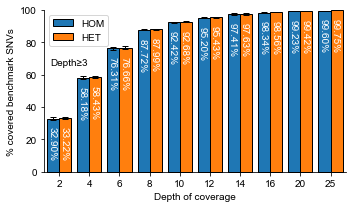

In [7]:
min_depth = 3
colors = ["C0", "C1"]

plt.figure(figsize=(5, 3))

for i, s in enumerate(["HOM", "HET"]):
    rows = []
    for rep in repeats:
        ps = [] 
        for cov in covs:
            d = snv_depths[("NanoSSCell", cov, rep)]
            p = 1 - sum(d[s].get(j, 0) for j in range(min_depth)) / sum(d[s].values())
            p = p * 100
            ps.append(p)
        rows.append(ps)
    df = pd.DataFrame(rows)
    df.index = repeats
    df.columns = covs
    
    ys = df.mean(axis=0)
    yerr = df.std(axis=0)
    xs = np.arange(len(ys))
    
    # label = "Homozygous SNVs" if s == "HOM" else "Heterouzygous SNVs"
    label = s
    plt.bar(xs + i * 0.4 - 0.2, ys, yerr=yerr, lw=1, width=0.4,
            clip_on=False, color=colors[i], edgecolor="black", 
            error_kw={"lw": 1, "capsize": 3}, label=label)
    for x, y in zip(xs, ys):
        plt.text(x + i * 0.4 - 0.2 - 0.05, y - 5, "%.2f%%" % y, 
                 ha="center", rotation=-90, va="top", color="white")
        
plt.text(-0.3, 70, "Depth≥%d" % min_depth, va="top")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.xticks(xs, covs)
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.ylim(0, 100)
plt.xlabel("Depth of coverage")
plt.ylabel("% covered benchmark SNVs")
plt.legend(loc="upper left", bbox_to_anchor=(0, 1), frameon=True)
plt.tight_layout()
plt.savefig("figures/covered_benchmark_het_snvs.pdf", dpi=300)

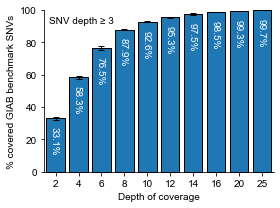

In [8]:
min_depth = 3

plt.figure(figsize=(4, 3))

rows = []
for rep in repeats:
    ps = [] 
    for cov in covs:
        d = snv_depths[("NanoSSCell", cov, rep)]
        d1 = defaultdict(int)
        for k, v in d["HOM"].items():
            d1[k] += v
        for k, v in d["HET"].items():
            d1[k] += v
        d = d1
        p = 1 - sum(d[j] for j in range(min_depth)) / sum(d.values())
        p = p * 100
        ps.append(p)
    rows.append(ps)
df = pd.DataFrame(rows)
df.index = repeats
df.columns = covs
ys = df.mean(axis=0)
yerr = df.std(axis=0)
xs = np.arange(len(ys))

plt.bar(xs , ys, yerr=yerr, lw=1, width=0.8, clip_on=False, color="C0", edgecolor="black", error_kw={"lw": 1, "capsize": 3})
for x, y in zip(xs, ys):
    plt.text(x - 0.05, y - 5, "%.1f%%" % y, ha="center", rotation=-90, va="top", color="white")
plt.text(-0.3, 96, "SNV depth ≥ %d" % min_depth, va="top")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.xticks(xs, covs)
plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
plt.ylim(0, 100)
plt.xlabel("Depth of coverage")
plt.ylabel("% covered GIAB benchmark SNVs")
plt.tight_layout()
plt.savefig("figures/covered_benchmark_snvs.pdf", dpi=300)